# Quiz 2

Esta actividad tiene como objetivo general, aplicar los conceptos que han sido abordados durante el curso de aprendizaje profundo para construir:

*   Los conjuntos de datos de entrenamiento, validación y pruebas
*   Los generadores de datos
*   Un modelo que permita identificar la acción que se realiza en un video de entrada.
*   Entrenar, validar y probar el modelo base.

Antes de iniciar con la actividad, descarga el archivo [UFC5.zip](https://drive.google.com/file/d/1L--lYpBZkwpKkJ93X4xfmSbXePA8uAkO/view?usp=sharing) que contiene los videos disponibles.

```
# Descomprimir archivo
!unzip '/path/UFC5.zip'
```

Los videos se encuentran organizados en las siguientes carpetas:

* Biking
* HorseRace
* IceDancing
* Punch
* TaiChi


El nombre de cada carpeta corresponde a la acción que se realiza en los videos almacenado en ella. Por ejemplo, en una carpeta llamada ´VolleyballSpiking´ se tendría el siguiente video:

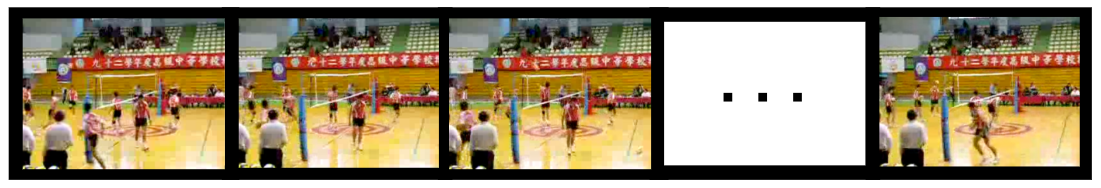



## ¿Trabajar con video?

Un video esta compuesto por una secuencia de frames (imágenes) que fue grabado a cierta frecuencia de muestro (por ejemplo 24 frames por segundo). A continuación, tienes a tus disposición algunas funciones de utilería que te permiten cargar un video a memoria (a partir de su path) como una secuencia de frames en formato de imágenes RGB.

In [2]:
import cv2 as cv2
import numpy as np

In [5]:
# Algunos hiperparámetros que te conviene definir para el desarrollo de tu actividad
# Al definir los hiperparámetros también es importante que consideres su impacto en el tiempo que tienes disponible para realizar la actividad

IMG_SIZE = 75
MAX_SEQ_LENGTH = 151
NUM_FEATURES = 2048

BATCH_SIZE = 8
EPOCHS = 10

In [3]:
# Los frame podrían no ser rectangulares, 
# Tomemos un recuadro del centro del frame
def crop_csquare(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [6]:
def load_video(path, max_frames=MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_csquare(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


## Videos a secuencia de imágenes RGB

Verifiquemos el funcionamiento de nuestras funciones, cargando dos videos y verificando las dimensiones del tensor que genera.

In [177]:
path1 = "C:/Users/nuno/Desktop/deep-learning-data/exam2/UFC-5/Biking/v_Biking_g01_c01.avi"
path2 = "C:/Users/nuno/Desktop/deep-learning-data/exam2/UFC-5/IceDancing/v_IceDancing_g01_c01.avi"
frames_v1=load_video(path1, max_frames=MAX_SEQ_LENGTH)
frames_v2=load_video(path2, max_frames=MAX_SEQ_LENGTH)

In [178]:
print(frames_v1.shape)
print(frames_v2.shape)

(151, 75, 75, 3)
(151, 75, 75, 3)


## Evaluación de la actividad

La actividad será evaluada de la siguiente manera:
*   Implementación de la solución:
> - Generador de datos (10 pts)
> - Aumento de datos (5 pts)
> - Uso de una ConvNet preentrenado como encoder (25 pts)
> - Uso de capas recurrentes para la secuencia de frames (25 pts)
> - Uso de Callbacks durante el entrenamiento (5 pts)

*   Documentación de su solución
> - Descripción de cada celda de código (10 pts)
> - Summary del modelo (2.5 pts)
> - Plot del modelo (2.5 pts)
> - Interpretación de gráficas de entrenamiento y validación (5 pts)
*   Desempeño del modelo
> - Documentación de ajuste de hiperparámetros y cambios en el desempeño de su modelo base (15 pts)
> - Accuracy < 70% (0 pts)
> - Accuracy >=70% y <=80% (10 pts)
> - Accuracy >=80% y <=90% (15 pts)
> - Accuracy >90% (20 pts)




## ¡Buena suerte!

Fecha de máxima de entrega: ***Lunes 8 de mayo, 21:50h***

Importar todas las librerias necesarias.

In [8]:
import os
import random
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras.layers import Dense, Input, Dropout, TimeDistributed
from tensorflow.keras.models import Model

La siguiente celda de código es por que mi enviroment deja sin funcionar cuando intento gráficar.

In [3]:
#because my emviroment is crasing when trying to plot
#https://stackoverflow.com/questions/59576397/python-kernel-dies-on-jupyter-notebook-with-tensorflow-2
#https://github.com/openai/spinningup/issues/16
#https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK']='True'

IMG_SIZE = 75
MAX_SEQ_LENGTH = 10
NUM_FEATURES = 2048
FRAME_STEP = 5
BATCH_SIZE = 8
EPOCHS = 5
DATASET_SIZE = 676

Lo primero es modificar las funciones para procesar y aumentar los videos para que funcione con *data.dataset* ya que solo permite tensores. La ventaja de usar data.dataset es que no carga todo en memoria.

*format_frames* convierte las matrices que representa el video a escala de 0 a 1 y ajusta el tamaño a *IMG_SIZE* para que todos sean iguales y en forma de tensores.

In [4]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    #frame = tf.image.resize_with_pad(frame, *output_size)
    frame = tf.image.resize(frame, output_size)
    return frame

*frames_from_video_file* de un path lee el video, lo acorta o aumenta a *n_frames*, y lo hace con un secuencacia cada *frame_step*.
frame_step indica cada cuantos frames se va a guardar un frame. De otra manera los primeros 10 frames serían usados, lo cual es menos de un segundo. Usando un espaciado da la posibilidad de tener más contexto. Al final, usando *format_frames* retorna un arreglo de numpy de forma (n_frames, IMG_SIZE, channels).

In [5]:
def frames_from_video_file(video_path, n_frames, output_size = (75,75), frame_step = 5):
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    
    return result

La siguiente clase es el generador de imagenes. Regresa dos tensores a partir de un directorio que lee todos los archivos y carpetas:
- EL primero tensor siendo el video usando las funciones anteriores.
- El segundo tensor es la clase. Un tensor de formato entero usando un diccionario.

In [6]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):

        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {"Biking": 0,
                                    "HorseRace":1,
                                    "IceDancing":2,
                                    "Punch":3,
                                    "TaiChi":4}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths] 
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames) 
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label

La siguiente celda define el directorio, asigna el generador a una variable para probarla, imprimiendo la forma de los tensores de la primera observación.

In [11]:
download_dir = pathlib.Path("C:/Users/nuno/Desktop/deep-learning-data/exam2/UFC-5/")
fg = FrameGenerator(download_dir, MAX_SEQ_LENGTH, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 75, 75, 3)
Label: 1


La siguiete celda crea el *dataset* y los divide en entrenamiento y prueba.

In [29]:
# Create the data set
dataset = tf.data.Dataset.from_generator(FrameGenerator(download_dir, MAX_SEQ_LENGTH, training=True), output_types=(tf.float32, tf.int16))

# dataset = (dataset
#                 .cache()
#                 .shuffle(DATASET_SIZE)
#                 .batch(BATCH_SIZE)
#                 .prefetch(AUTOTUNE)
#                 )

train_size = int(0.8 * DATASET_SIZE)
validation_size = int(0.2 * DATASET_SIZE)

train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

train_dataset = (train_dataset
                 .cache()
                 .shuffle(train_size)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTOTUNE)
                 )
validation_dataset = (validation_dataset
                 .cache()
                 .shuffle(validation_size)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTOTUNE)
                 )


In [28]:
for frames, labels in validation_dataset.take(2):
    print(labels, frames.shape)

tf.Tensor(4, shape=(), dtype=int16) (10, 75, 75, 3)
tf.Tensor(0, shape=(), dtype=int16) (10, 75, 75, 3)


In [27]:
for frames, labels in train_dataset.take(2):
    print(labels, frames.shape)

tf.Tensor(2, shape=(), dtype=int16) (10, 75, 75, 3)
tf.Tensor(4, shape=(), dtype=int16) (10, 75, 75, 3)


Importa un modelo, InceptionV3, preentrenado como encoder para extraer atributos importantes de los frames. Por que esta usando enteros en lugar de one-hot se debe usar Sparse Categorical Cross Entropy.

In [30]:
input_shape = (MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3)
num_classes = 5

cnn = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
cnn.trainable = False

TimeDistributed ayuda a evaluar usar el modelo con la secuencia de imagenes del video. GRU utiliza el mecanismo para recordar valores pasados.

In [31]:
inputs = Input(shape=input_shape)
x = keras.layers.TimeDistributed(cnn)(inputs)
x = keras.layers.GRU(256, return_sequences=False)(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

rnn = Model(inputs=inputs, outputs=outputs)
rnn.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy())

filepath = "C:/Users/nuno/Desktop/deep-learning-data/exam2/tmp/video_classifier"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, save_weights_only=True, save_best_only=True, verbose=1)

Antes de entrenar visualizar el modelo para segurar que este correcto.

In [32]:
rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 75, 75, 3)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 2048)         21802784  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 256)               1771008   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 23,575,077
Trainable params: 1,772,293
Non-trainable params: 21,802,784
_________________________________________

Proceder al entrenamiento guardando los pesos del mejor modelo para no perderlos en caso de una eventualidad.

In [33]:
history = rnn.fit(x=train_dataset,
                  epochs=EPOCHS,
                  callbacks=[checkpoint],
                  validation_data=validation_dataset
    )

Epoch 1/5
     68/Unknown - 104s 429ms/step - loss: 0.8386 - sparse_categorical_accuracy: 0.7185
Epoch 1: val_loss improved from inf to 0.32726, saving model to C:/Users/nuno/Desktop/deep-learning-data/exam2/tmp\video_classifier
68/68 [==============================] - 209s 2s/step - loss: 0.8386 - sparse_categorical_accuracy: 0.7185 - val_loss: 0.3273 - val_sparse_categorical_accuracy: 0.8971
Epoch 2/5
68/68 [==============================] - ETA: 0s - loss: 0.1680 - sparse_categorical_accuracy: 0.9463
Epoch 2: val_loss improved from 0.32726 to 0.20183, saving model to C:/Users/nuno/Desktop/deep-learning-data/exam2/tmp\video_classifier
68/68 [==============================] - 25s 369ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.9463 - val_loss: 0.2018 - val_sparse_categorical_accuracy: 0.9338
Epoch 3/5
68/68 [==============================] - ETA: 0s - loss: 0.0590 - sparse_categorical_accuracy: 0.9926
Epoch 3: val_loss improved from 0.20183 to 0.18609, saving model to C:/Us

Las siguientes gráficas indican que el entrenamiento y la validación convergen rápidamente. 4 epocas fueron sufientes para ajustar el modelo con un accuracy de 95% usando el dataset de validación.

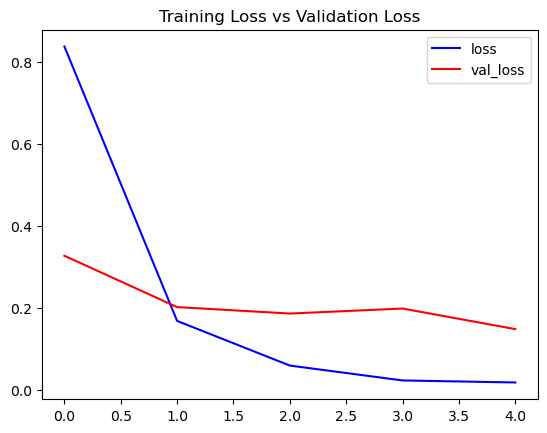

In [35]:
def plot(var1, var2, plot_name):
    # Get the loss metrics from the trained model
    c1 = history.history[var1]
    c2 = history.history[var2]

    epochs = range(len(c1))

    # Plot the metrics
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.legend()

plot( 'loss', 'val_loss', 'Training Loss vs Validation Loss')

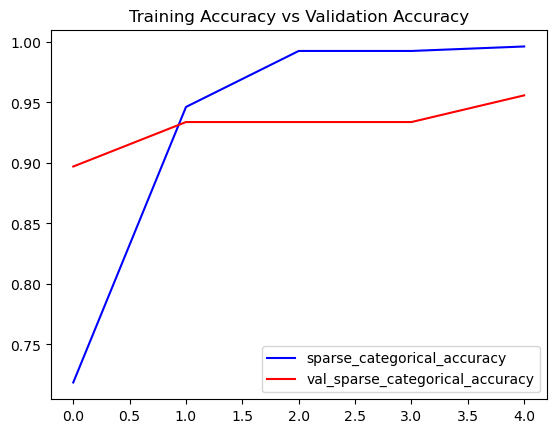

In [36]:
plot( 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy', 'Training Accuracy vs Validation Accuracy')